In [1]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
%matplotlib inline
import random
from datetime import datetime
from faker import Faker

**Steps:**
1. [x] Decide the variables 
2. [x] Fake data for one student 
3. [x] Fake data for one class
4. [ ] Fake data for multiple classes 
5. [x] Fake data for multiple terms 

---
### Decide the variables:

In [2]:
# Basic_Info:
    # id 
    # f_name
    # l_name
    # gender
    # race
    # birth_dt
    # address
    # email
    
# Academic_Performance:
    # Grades of quizzes, exams, home assignments
    # Attendance
    # Number of on-time, late, and missed assignments
    # Number of accesses to LMS
    # Average time spent on LMS
    # Messages on LMS (for example, number of questions and responses on the discussion forum)

---
### Fake data for one student:

In [3]:
import bisect

def bi_search(arr, x): # binary search
    i = bisect.bisect(arr, x)-1
    if i != len(arr) and arr[i] == x:
        return i
    return False

bi_search(np.asarray([1, 2, 5, 8]), 6)

False

In [4]:
def ewma_predict(series, span=3, jump=1): # jump is the diff in time bw the date of prediction & the last observation
    if len(series) == 1: #if the series has only 1 element
        return series.iloc[0]
    
    s_clone = series # shallow copy for efficiency
    
    if s_clone.iloc[-1] == 0:   # if the most recent grade is from a missed assigment, i.e. grade = 0
        s_clone = series.copy() # deep copy
        s_clone.iloc[-1] = s_clone.ewm(span=span).mean().iloc[-1]
        # set that grade equal to the ewma
        # this is to alleviate the disastrous effect of a grade of 0 
    
    inter = s_clone.ewm(span=span).mean().iloc[-1]
    
    differences = s_clone.diff()
    slope = differences.ewm(span=span).mean().iloc[-1]
    
    return inter + slope*jump

In [5]:
def miss_chance(index, cum_mean_grade, gra_slope=0.5):
    if index < 2: # first few assignments
        return random.betavariate(1.1, 15)*100 # very unlikely to miss on the first few assignments
    
    if cum_mean_grade >= 60: # D- or higher
        missed = random.betavariate(1.1, 10)*100 - gra_slope*np.power(cum_mean_grade, 0.73)
    else:
        missed = random.betavariate(1.5, 8)*100 - (gra_slope-0.1)*np.power(cum_mean_grade, 0.73)
        # more likely to miss assignment if mean grade is < 60
    
    return missed

In [6]:
def fake_student_grades(grade1_mu, grade1_std, n_quiz, n_home, last_home_idx, n_exams, exam1_idx):
    total_n_grades = n_home + n_quiz + n_exams 
    # total number of grades: home assignments, quizzes, exams
    # the indexes of range(0, total_n_grades) are the "positions" of each grade
    
    home_pos = np.round(np.linspace(start=0, stop=last_home_idx, num=n_home)).astype(int)
    # the "positions" of the home assignments
    # suppose that the 1st grade is from a home assignments: start=0
    
    exam_pos = np.round(np.linspace(start=exam1_idx, stop=total_n_grades-1, num=n_exams)).astype(int)
    # the "positions" of the exams
    # suppose that the final grade is from an exam: stop=total_n_grades-1
    
    for i, pos in enumerate(exam_pos):
        if bi_search(home_pos, pos): # check if the positions of home assignments and exams overlap 
            exam_pos[i] += 1         # if so, add 1 to the position of the exam
    
    home_exam_pos = np.concatenate((home_pos, exam_pos))
    
    quiz_pos = [p for p in range(total_n_grades) if p not in home_exam_pos]
    # the rest is positions of the quizzes
    
    grade1 = int(round(random.gauss(grade1_mu, grade1_std)))
    grade1 = grade1 if grade1 <= 100 else 100 # can't be > 100
    grade1 = grade1 if grade1 >= 0 else 0 # can't be < 0
    grade_series = pd.Series([grade1])
    
    var_std = random.uniform(1, 3)
    # print("Variation std:", var_std)
    
    for g in range(1, total_n_grades):
        span = 3  
        home_idx = bi_search(home_pos, g)
        if home_idx: # if it's a home assignment:
            cum_mean_grade = grade_series.mean()
            
            if miss_chance(home_idx, cum_mean_grade)>40:
                grade_series = grade_series.append(pd.Series(0)) # missed if miss_chance > 40%
                continue

            variation = random.gauss(1, var_std) # grades of home assignments tend to be higher: mu=1
        
        elif bi_search(quiz_pos, g): # quiz
            variation = random.gauss(0, var_std)
        
        else: # exam
            variation = random.gauss(-1, var_std) # grades of exams tend to be lower: mu=-1
            span = 5 # exams tend to cover a larger range of content
        
        next_grade = ewma_predict(grade_series, span) + variation
        next_grade = next_grade if next_grade <= 100 else 100 # can't be > 100
        next_grade = next_grade if next_grade >= 0 else 0 # can't be < 0
        next_grade = pd.Series(next_grade).round()
        
        grade_series = grade_series.append(next_grade)
        #print(grade_series)
    
    home_series = grade_series.iloc[home_pos]
    exam_series = grade_series.iloc[exam_pos]
    quiz_series = grade_series.iloc[quiz_pos]
    
    # reset index:
    for s in [home_series, exam_series, quiz_series]:
        s.reset_index(inplace=True, drop=True)
        
    return grade_series, home_series, exam_series, quiz_series

args = { 
    'grade1_mu':78, 
    'grade1_std': 5, 
    'n_quiz': 2,  
    'n_home': 3, 
    'last_home_idx': 4, # starts at 0
    'n_exams': 0, 
    'exam1_idx': 0      # if there's no exam, put 0
}

fake_student_grades(**args)

(0    80.0
 0    82.0
 0    85.0
 0    87.0
 0    88.0
 dtype: float64,
 0    80.0
 1    85.0
 2    88.0
 dtype: float64,
 Series([], dtype: float64),
 0    82.0
 1    87.0
 dtype: float64)

In [7]:
def fake_student_submission(mean_grade, home_grade_series, ontime_slope=0.3, **kwargs):
    missed = home_grade_series.loc[home_grade_series==0].count()
    missed = missed*100/len(home_grade_series)
    missed = float('{:.2f}'.format(missed)) # round to 2 decimal places
    
    ontime_and_late = 100 - missed 
    
    ontime_slope = ontime_slope if ontime_slope >= 0.3 else 0.3
    # 0.3 is the default slope bw grade and on_time submissions
    # some classes may have a stricter policy regarding deadlines
    
    if mean_grade >= 70: # C- or higher
        on_time = random.betavariate(13, 2)*100 + ontime_slope*np.power(mean_grade, 0.73)
    else:
        on_time = random.betavariate(60, 25)*100 + (ontime_slope-0.1)*np.power(mean_grade, 0.73)
        # more likely to have late submissions if mean grade is < 70
        # the relation bw grade and on-submission is weaker: gra_slode-0.1
    
    on_time = on_time if on_time<100 else 100 # cannot be > 100
    on_time = (on_time*ontime_and_late)/100
    on_time = float('{:.2f}'.format(on_time))
    
    late = ontime_and_late - on_time
    late = float('{:.2f}'.format(late))
    
    return on_time, late, missed

fake_student_submission(70, pd.Series([65, 60, 10, 55, 67]))

(78.66, 21.34, 0.0)

In [8]:
def fake_student_attendance(mean_grade, att_min_gra_slope=0.4, att_max_gra_slope=0.6, 
                            hi_beta_para=(13, 2), lo_beta_para=(30, 25), **kwargs):
    # slope is from a uniform distribution
    slope = random.uniform(att_min_gra_slope, att_max_gra_slope)
    # print('slope:', slope)

    # intercept is from a beta distribution
    if mean_grade >= 70: # C- or higher
        inter = random.betavariate(hi_beta_para[0], hi_beta_para[1]) * 100
        attendance = np.power(mean_grade, 0.7)*slope + inter
    else:
        inter = random.betavariate(lo_beta_para[0], lo_beta_para[1]) * 100
        attendance = np.power(mean_grade, 0.6)*slope + inter
    # print('Inter:', inter)
     
    attendance = attendance if attendance<100 else 100 # cannot be > 100
    attendance = float('{:.2f}'.format(attendance))    # round to 2 decimal places
    
    return attendance

print(fake_student_attendance(90))
print(fake_student_attendance(60))

100.0
74.51


In [9]:
def fake_student_LMS_accesses(mean_grade, acc_gra_slope_mu=1, acc_gra_slope_std=0.1, 
                              acc_inter_mu=3, acc_inter_std=0.1, **kwargs): 
    # weekly LMS accesses
    gra_slope = random.gauss(acc_gra_slope_mu, acc_gra_slope_std)
    inter = random.gauss(acc_inter_mu, acc_inter_std) # account for other random factors than grade
    
    # the default acc_inter_mu = 3
    # given that acc_gra_slope_mu = 1
    # a student with a grade of 90 is expected to have 6 accesses/week
    # to adjust this expectation, change the acc_inter_mu
    
    weekly_accesses = gra_slope*(mean_grade/10) - inter
    weekly_accesses = weekly_accesses if weekly_accesses > 0 else 0.1
    # if the returned result is =< 0, that means we get a very small value
    weekly_accesses = float('{:.2f}'.format(weekly_accesses))
    
    return weekly_accesses

print(fake_student_LMS_accesses(90))
print(fake_student_LMS_accesses(60))
        
# this model is strong!
# given that the slope can get as low as 0.6:
# 6*0.6 = 3.6 - 3 = 0.6 > 0.1

5.78
1.97


In [10]:
def fake_student_LMS_time(mean_grade, weekly_accesses, tim_gra_slope_mu=1, norm_tim_gra_slope_std=0.1, 
                          tim_inter_mu=2, tim_inter_std=0.1, tim_acc_slope_mu=0.3, tim_acc_slope_std=0.01, **kwargs):
    
    # average time spent per session in minutes
        
    # the relation to grade is not clear
    # a high grade may indicate that a student is intelligent & understands things quickly
    # or she's diligent and hard-working
    
    if mean_grade >= 83: # B or higher
        gra_slope = random.gauss(tim_gra_slope_mu, norm_tim_gra_slope_std+0.05)
        # the slope varies more for students with high grades
    else:
        gra_slope = random.gauss(tim_gra_slope_mu, norm_tim_gra_slope_std)
        
    acc_slope = random.gauss(tim_acc_slope_mu, tim_acc_slope_std) # higher freq of accesses often means less session time
    inter = random.gauss(tim_inter_mu, tim_inter_std) # account for other random factors than grade
    
    session_time = gra_slope*(mean_grade/10) - acc_slope*np.power(1.2, weekly_accesses) - inter
    
    session_time = session_time if session_time > 0 else 0.1 
    # if the returned result is =< 0, that means we get a very small value
    session_time = float('{:.2f}'.format(session_time))
    
    # adjust the time_inter_mu to raise/lower the (expected) session time
    
    return session_time

fake_student_LMS_time(90, 6)

4.49

In [11]:
def fake_student_LMS_mess(mean_grade, n_mess_mu, mess_gra_slope=0.13, **kwargs): 
    # n_mess_mu is the mean num of messages of the whole class
    if mean_grade >= 70: # C- or higher
        lambd = 1.0/(n_mess_mu+0.5)
        # the mean number of messages is higher for students with score >= 70
    else:
        n_mess_mu = n_mess_mu-2
        n_mess_mu = n_mess_mu if n_mess_mu > 0 else 0.1
        lambd = 1.0/(n_mess_mu)
        # the mean number of messages is lower for students with score < 70
        mess_gra_slope = mess_gra_slope - 0.03
        # the relation bw grade and number of messages is also weaker
    
    inter = random.expovariate(lambd) # intercept is from an exponential dist
    
    mess_num = mess_gra_slope*(mean_grade/10) + (inter - 7*mess_gra_slope)
    mess_num = int(round(mess_num))
    mess_num = mess_num if mess_num > 0 else 0
    
    return mess_num

print(fake_student_LMS_mess(90, 3))
print(fake_student_LMS_mess(70, 3))
print(fake_student_LMS_mess(60, 3))

3
1
1


(array([1., 2., 8., 5., 2., 7., 1., 2., 1., 1.]),
 array([58. , 61.9, 65.8, 69.7, 73.6, 77.5, 81.4, 85.3, 89.2, 93.1, 97. ]),
 <a list of 10 Patch objects>)

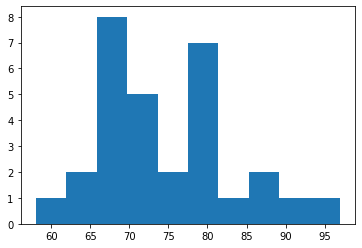

In [12]:
class_size = 30
quiz1_grades = [] 

for i in range(class_size):
    quiz1_grades.append(int(round(random.gauss(mu=75, sigma=10))))
    
plt.hist(quiz1_grades)

(array([ 3., 10.,  6.,  3.,  2.,  4.,  0.,  0.,  0.,  2.]),
 array([2.82 , 3.357, 3.894, 4.431, 4.968, 5.505, 6.042, 6.579, 7.116,
        7.653, 8.19 ]),
 <a list of 10 Patch objects>)

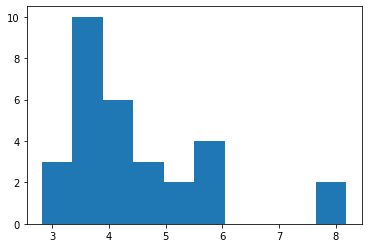

In [13]:
accesses = [fake_student_LMS_accesses(g) for g in quiz1_grades]
plt.hist(accesses)

(array([7., 9., 6., 1., 3., 2., 1., 0., 0., 1.]),
 array([0. , 0.9, 1.8, 2.7, 3.6, 4.5, 5.4, 6.3, 7.2, 8.1, 9. ]),
 <a list of 10 Patch objects>)

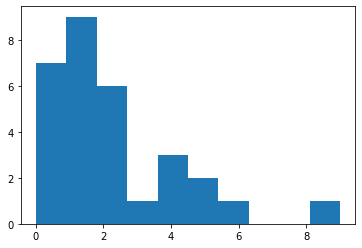

In [14]:
mess = [fake_student_LMS_mess(g, 3) for g in quiz1_grades]
plt.hist(mess)

---
### Fake data for one class:

In [15]:
def fake_class_basic_info(class_size, birth_dt_start, birth_dt_end):
    columns = ['id', 'f_name', 'l_name', 'gender', 'race', 'birth_dt', 'address', 'email']
    info_df = pd.DataFrame(columns=columns)
    
    possible_races = ['White', 'Black', 'Native', 'Asian', 'Pacific Islander', 'Mixed']
    race_prob = [0.763, 0.134, 0.013, 0.059, 0.002, 0.029]
    
    # Faker.seed(1234) # for producing the same results 
    fake = Faker()
    
    for s in range(class_size):
        student = {
            'id': fake.ssn(),
            'l_name': fake.last_name(),
            'gender': random.choice(['M', 'F']),
            'race': np.random.choice(possible_races, replace=True, p=race_prob),
            'birth_dt': fake.date_between_dates(birth_dt_start, birth_dt_end),
            'address': fake.address(),
            'email': fake.free_email()
        }    
        student['f_name'] = fake.first_name_male() if student['gender']=='M' else fake.first_name_female()
        
        info_df = info_df.append(student, ignore_index=True)
    
    return info_df

class20_basic_info = fake_class_basic_info(30, datetime(1997, 1, 1), datetime(2001, 12, 31))
class20_basic_info

,id,f_name,l_name,gender,race,birth_dt,address,email
0,305-66-9990,Robert,Payne,M,White,1997-08-10,"76914 Nathaniel Ridges\nLake Daniel, KS 30186",danieljuarez@yahoo.com
1,591-08-3033,Amy,Berry,F,White,1999-11-03,"2318 Perez Cape Suite 058\nNew Samantha, AK 74536",ntownsend@yahoo.com
2,234-59-6481,Robin,York,F,White,2000-12-30,"3646 Nathan Garden\nElizabethchester, NE 84514",jodibranch@gmail.com
3,057-89-2389,Alejandro,Wade,M,White,2001-11-09,"690 Sharon Cove\nPort Steven, PA 15185",holderderek@yahoo.com
4,440-08-6392,Darryl,Rogers,M,White,1999-11-24,"782 Jean Brooks Suite 563\nRusselltown, AK 41863",david89@hotmail.com
5,421-62-4115,Anthony,Moran,M,White,2000-03-09,"5022 Henry Light Suite 782\nPort Luis, DE 37677",roseschmitt@yahoo.com
6,195-51-6448,Jonathan,Freeman,M,White,1999-10-28,"27982 Smith Drives\nAngelastad, WV 65569",bushlinda@gmail.com
7,476-57-7836,Rodney,Dawson,M,White,1998-06-19,"36158 Angela Neck\nWest Melissafurt, RI 13063",williamsmelissa@gmail.com
8,575-41-3383,Bradley,Miller,M,White,2001-06-02,"816 Robinson Parks\nNew Adrienne, IL 09405",jonescynthia@hotmail.com
9,499-89-8516,Morgan,Sanchez,F,White,2001-03-03,"407 Bowers Path Suite 501\nSouth Johnview, CA ...",nguyenanna@yahoo.com


In [16]:
def fake_class_performance(class_size, n_mess_mu, grade1_mu, grade1_std, n_total_quiz, n_avail_quiz, 
                           n_total_home, n_avail_home, latest_home_idx, 
                           n_total_exams, n_avail_exams, exam1_idx, **paras):
    
    home_cols = ['home{}'.format(i+1) for i in range(n_total_home)]
    quiz_cols = ['quiz{}'.format(i+1) for i in range(n_total_quiz)]
    exam_cols = ['exam{}'.format(i+1) for i in range(n_total_exams)]
    
    columns = ['ontime', 'late', 'missed', 'attendance', 'LMS_accesses', 'LMS_time', 'LMS_mess']
    columns = home_cols + quiz_cols + exam_cols + columns
        
    performance_df = pd.DataFrame(columns=columns)
    
    for st in range(class_size):
        st_all_gr, st_ho_gr, st_exam_gr, st_quiz_gr = fake_student_grades(grade1_mu, grade1_std, n_avail_quiz, n_avail_home, 
                                                                          latest_home_idx, n_avail_exams, exam1_idx)
                
        ho_dict = {'home{}'.format(i+1): hg for i, hg in st_ho_gr.items()}
        quiz_dict = {'quiz{}'.format(i+1): tg for i, tg in st_quiz_gr.items()}
        exam_dict = {'exam{}'.format(i+1): eg for i, eg in st_exam_gr.items()}
        
        mean_gr = st_all_gr.mean()
        
        st_ontime, st_late, st_missed = fake_student_submission(mean_gr, st_ho_gr, **paras)
        st_attendance = fake_student_attendance(mean_gr, **paras)
        st_LMS_accesses = fake_student_LMS_accesses(mean_gr, **paras)
        st_LMS_time = fake_student_LMS_time(mean_gr, st_LMS_accesses, **paras)
        st_LMS_mess = fake_student_LMS_mess(mean_gr, n_mess_mu, **paras)
        
        student = {
            'ontime': st_ontime,
            'late': st_late,
            'missed': st_missed,
            'attendance': st_attendance,
            'LMS_accesses': st_LMS_accesses,
            'LMS_time': st_LMS_time,
            'LMS_mess': st_LMS_mess
        }
        
        student = {**student, **ho_dict, **quiz_dict, **exam_dict}
        
        performance_df = performance_df.append(student, ignore_index=True)
    
    return performance_df
        

args = {
    'class_size': 30, 
    'n_mess_mu': 2, 
    'grade1_mu': 85, 
    'grade1_std': 5, 
    'n_total_quiz': 5, 
    'n_avail_quiz': 2, 
    'n_total_home': 5, 
    'n_avail_home': 3, 
    'latest_home_idx': 4, # idx starts at 0  
    'n_total_exams': 2, 
    'n_avail_exams': 1, 
    'exam1_idx': 3,       # idx starts at 0
}

class20_performance = fake_class_performance(**args)
class20_performance

,home1,home2,home3,home4,home5,quiz1,quiz2,quiz3,quiz4,quiz5,exam1,exam2,ontime,late,missed,attendance,LMS_accesses,LMS_time,LMS_mess
0,83.0,83.0,90.0,NaN,NaN,84.0,94.0,NaN,NaN,NaN,84.0,NaN,69.09,30.91,0.0,99.82,3.12,7.49,1.0
1,77.0,77.0,74.0,NaN,NaN,77.0,73.0,NaN,NaN,NaN,75.0,NaN,92.94,7.06,0.0,91.19,4.17,4.64,6.0
2,82.0,83.0,82.0,NaN,NaN,83.0,84.0,NaN,NaN,NaN,77.0,NaN,100.00,0.00,0.0,89.59,4.39,5.97,3.0
3,99.0,96.0,95.0,NaN,NaN,97.0,97.0,NaN,NaN,NaN,96.0,NaN,100.00,0.00,0.0,97.30,7.38,6.86,5.0
4,82.0,79.0,78.0,NaN,NaN,80.0,80.0,NaN,NaN,NaN,79.0,NaN,96.81,3.19,0.0,100.00,3.40,5.52,1.0
5,83.0,83.0,82.0,NaN,NaN,83.0,80.0,NaN,NaN,NaN,83.0,NaN,100.00,0.00,0.0,91.72,6.51,5.03,1.0
6,83.0,87.0,88.0,NaN,NaN,86.0,92.0,NaN,NaN,NaN,86.0,NaN,85.55,14.45,0.0,89.99,6.37,1.42,4.0
7,84.0,83.0,82.0,NaN,NaN,83.0,84.0,NaN,NaN,NaN,80.0,NaN,86.67,13.33,0.0,91.99,4.37,4.91,1.0
8,87.0,86.0,86.0,NaN,NaN,85.0,86.0,NaN,NaN,NaN,85.0,NaN,86.78,13.22,0.0,83.27,5.16,6.18,2.0
9,89.0,88.0,83.0,NaN,NaN,87.0,80.0,NaN,NaN,NaN,87.0,NaN,91.64,8.36,0.0,81.06,5.88,5.71,4.0


In [17]:
def get_final_grade(performance_df, assessment_idxes, weight_series):
    performance_df['final_grade'] = (performance_df.iloc[:, assessment_idxes]
                                     *np.asarray(weight_series)).sum(axis=1, skipna=False)
    # round to 2 dec places:
    performance_df['final_grade'] = performance_df.final_grade.apply(lambda x: float('{:.2f}'.format(x)))
    
    weight_df = pd.DataFrame({'assessment': performance_df.iloc[:, assessment_idxes].columns, 
                              'weight': weight_series})
    
    return weight_df

In [18]:
assessment_idx_list = [i for i in range(12)] + [15] # idx 15 is attendance
weights = [0.04 for i in range(5)] + [0.06 for i in range(5)] + [0.2 for i in range(2)] + [0.1]
weight_df = get_final_grade(class20_performance, assessment_idx_list, weights)
weight_df

,assessment,weight
0,home1,0.04
1,home2,0.04
2,home3,0.04
3,home4,0.04
4,home5,0.04
5,quiz1,0.06
6,quiz2,0.06
7,quiz3,0.06
8,quiz4,0.06
9,quiz5,0.06


In [19]:
# join on index to combine the two df
# assume there's no relationship bw basic info & academic performance

class20_df = class20_basic_info.join(class20_performance)
class20_df['course_code'] = 'CS_320'
class20_df['term_code'] = 'SP_2020' 

In [20]:
# Fake data for another term:
class19_basic_info = fake_class_basic_info(28, datetime(1996, 1, 1), datetime(2000, 12, 31))

args = {
    'class_size': 28, 
    'n_mess_mu': 3, 
    'grade1_mu': 84, 
    'grade1_std': 3, 
    'n_total_quiz': 4, 
    'n_avail_quiz': 4, 
    'n_total_home': 5, 
    'n_avail_home': 5, 
    'latest_home_idx': 9, # idx starts at 0  
    'n_total_exams': 2, 
    'n_avail_exams': 2, 
    'exam1_idx': 3,       # idx starts at 0
     # **paras:
    'acc_inter_mu': 2.5,
}

class19_performance = fake_class_performance(**args)

assessment_idx_list = [i for i in range(11)] + [14] # idx 14 is attendance
weights = [0.05 for i in range(5)] + [0.07 for i in range(4)] + [0.2 for i in range(2)] + [0.07]
weight_df = get_final_grade(class19_performance, assessment_idx_list, weights)

class19_df = class19_basic_info.join(class19_performance)
class19_df['course_code'] = 'CS_320'
class19_df['term_code'] = 'SP_2019'

In [21]:
# Fake data for another term:
class18_basic_info = fake_class_basic_info(31, datetime(1995, 1, 1), datetime(1999, 12, 31))

args = {
    'class_size': 31, 
    'n_mess_mu': 2.2, 
    'grade1_mu': 85.5, 
    'grade1_std': 4, 
    'n_total_quiz': 4, 
    'n_avail_quiz': 4, 
    'n_total_home': 6, 
    'n_avail_home': 6, 
    'latest_home_idx': 10, # idx starts at 0. Note: the last index (11) must be of an exam. 
    'n_total_exams': 2, 
    'n_avail_exams': 2, 
    'exam1_idx': 4,       # idx starts at 0
     # **paras:
    'acc_inter_mu': 2.5,
    'ontime_slope': 0.32
}

class18_performance = fake_class_performance(**args)

assessment_idx_list = [i for i in range(12)] + [15] # idx 15 is attendance
weights = [0.04 for i in range(6)] + [0.07 for i in range(4)] + [0.2 for i in range(2)] + [0.08]
weight_df = get_final_grade(class18_performance, assessment_idx_list, weights)

class18_df = class18_basic_info.join(class18_performance)
class18_df['course_code'] = 'CS_320'
class18_df['term_code'] = 'SP_2018'

class18_performance

,home1,home2,home3,home4,home5,home6,quiz1,quiz2,quiz3,quiz4,exam1,exam2,ontime,late,missed,attendance,LMS_accesses,LMS_time,LMS_mess,final_grade
0,87.0,90.0,96.0,92.0,99.0,100.0,88.0,92.0,96.0,100.0,93.0,95.0,85.58,14.42,0.0,91.16,6.22,5.16,0.0,93.77
1,92.0,96.0,99.0,100.0,100.0,100.0,95.0,94.0,100.0,100.0,98.0,97.0,88.25,11.75,0.0,100.00,7.41,4.52,1.0,97.71
2,86.0,82.0,80.0,81.0,86.0,86.0,84.0,82.0,85.0,87.0,81.0,87.0,92.39,7.61,0.0,100.00,4.84,3.49,8.0,85.30
3,88.0,94.0,95.0,92.0,91.0,89.0,89.0,94.0,92.0,89.0,92.0,87.0,77.98,22.02,0.0,100.00,7.61,6.69,3.0,91.24
4,85.0,76.0,72.0,71.0,76.0,79.0,79.0,74.0,72.0,78.0,71.0,77.0,100.00,0.00,0.0,99.12,5.41,5.90,3.0,77.10
5,86.0,88.0,92.0,90.0,91.0,94.0,87.0,88.0,91.0,91.0,90.0,93.0,78.35,21.65,0.0,88.16,6.49,6.06,1.0,90.28
6,79.0,80.0,80.0,76.0,82.0,80.0,79.0,78.0,78.0,82.0,77.0,82.0,91.29,8.71,0.0,100.00,5.24,4.05,12.0,81.07
7,81.0,76.0,70.0,68.0,70.0,71.0,79.0,72.0,68.0,70.0,69.0,69.0,98.79,1.21,0.0,69.06,3.90,3.89,1.0,70.79
8,82.0,81.0,81.0,79.0,81.0,80.0,81.0,79.0,80.0,81.0,79.0,77.0,82.65,17.35,0.0,100.00,5.81,5.41,1.0,81.03
9,94.0,95.0,100.0,99.0,100.0,100.0,95.0,96.0,99.0,100.0,99.0,100.0,100.00,0.00,0.0,100.00,8.19,6.13,2.0,98.62


In [22]:
# Fake data for another term:
class17_basic_info = fake_class_basic_info(25, datetime(1994, 1, 1), datetime(1998, 12, 31))

args = {
    'class_size': 25, 
    'n_mess_mu': 2.7, 
    'grade1_mu': 87, 
    'grade1_std': 6, 
    'n_total_quiz': 5, 
    'n_avail_quiz': 5, 
    'n_total_home': 5, 
    'n_avail_home': 5, 
    'latest_home_idx': 10, # idx starts at 0  
    'n_total_exams': 2, 
    'n_avail_exams': 2, 
    'exam1_idx': 3,       # idx starts at 0
     # **paras:
    'acc_inter_mu': 3.2,
    'ontime_slope': 0.35,
    'tim_gra_slope_mu': 1.1
}

class17_performance = fake_class_performance(**args)
get_final_grade(class17_performance, assessment_idx_list, weights)
class17_df = class17_basic_info.join(class17_performance)
class17_df['course_code'] = 'CS_320'
class17_df['term_code'] = 'SP_2017'

In [23]:
# export to an Excel file:
#with pd.ExcelWriter('CS_320.xlsx') as writer:  
    #class20_df.to_excel(writer, sheet_name='SP_2020', index=False)
    #class19_df.to_excel(writer, sheet_name='SP_2019', index=False)
    #class18_df.to_excel(writer, sheet_name='SP_2018', index=False)
    #class17_df.to_excel(writer, sheet_name='SP_2017', index=False)

In [24]:
# arguments hacking:

def fa(a, **arg):
    return a

def fb(b, **arg):
    return b

def fc(c, **arg):
    return c

def bigf(**args):
    return fa(**args) + fb(**args) + fc(**args)

bigf(a=4, b=5, c=6)

15

In [25]:
assert False, "breakpoint"

AssertionError: breakpoint

# Creating Database using SQLite

In [26]:
import sqlite3
conn = sqlite3.connect('Student_Data.db')
c = conn.cursor()

In [27]:
c.execute(""" DROP TABLE Student_Info""")

Creating table student information

In [28]:
c.execute("""CREATE TABLE Student_Info (
        id text PRIMARY KEY,
        f_name text,
        l_name text,
        gender text,
        race text,
        birth_dt numeric,
        address text,
        email text
        )""")

In [29]:
import sqlalchemy
from sqlalchemy import create_engine
import pandas as pd

class_list = [class17_df, class18_df, class19_df, class20_df]
for i in class_list:
    student_data = i
    engine = sqlalchemy.create_engine('sqlite:///Student_Data.db', echo=False)
    df = pd.DataFrame(student_data, columns=['id', 'f_name','l_name','gender','race','birth_dt','address','email'])
    df.to_sql('Student_Info', con=engine, if_exists='append',index = False)
x = engine.execute('''SELECT * FROM Student_Info''')
for row in x.fetchmany(5):
    print (row)
x.close()    
#engine.commit()   

('276-03-1718', 'Matthew', 'Brennan', 'M', 'Black', '1995-01-17', '68609 Black Lock\nLake Gabriela, FL 54374', 'wcisneros@yahoo.com')
('836-91-2671', 'Kim', 'Beck', 'F', 'White', '1998-04-05', '4087 Williams Plaza Suite 510\nNew Aprilton, WY 13032', 'rcole@gmail.com')
('490-69-4479', 'Bonnie', 'Weaver', 'F', 'White', '1994-06-20', '425 Simmons Lodge\nEast Christopherport, LA 41013', 'enunez@hotmail.com')
('020-82-1466', 'Kimberly', 'Garcia', 'F', 'Pacific Islander', '1996-12-15', '864 Jacqueline Spurs\nNorth Jeremy, AZ 67834', 'ghall@hotmail.com')
('036-39-3002', 'Rodney', 'Gonzales', 'M', 'Black', '1997-02-01', '06623 Leslie Lodge Apt. 045\nWest Nicholasmouth, IN 59432', 'sylvia61@hotmail.com')


In [30]:
conn.commit()


Creating table Student profile

In [31]:
c.execute(""" DROP TABLE StudentProfile""")

In [32]:
c.execute("""CREATE TABLE StudentProfile (
        id text ,
        course_code text,
        term_code text,
        FOREIGN KEY(id) REFERENCES Student_Info(id)
        )""")

In [33]:
for i in class_list:
    student_data = i
    engine = sqlalchemy.create_engine('sqlite:///Student_Data.db', echo=False)
    df = pd.DataFrame(student_data, columns=['id', 'course_code', 'term_code'])
    df.to_sql('StudentProfile', con=engine, if_exists='append',index = False)
p = engine.execute('''SELECT rowid, id, course_code, term_code  FROM StudentProfile''')
for row in p.fetchmany(5):
    print (row)
p.close()  

(1, '276-03-1718', 'CS_320', 'SP_2017')
(2, '836-91-2671', 'CS_320', 'SP_2017')
(3, '490-69-4479', 'CS_320', 'SP_2017')
(4, '020-82-1466', 'CS_320', 'SP_2017')
(5, '036-39-3002', 'CS_320', 'SP_2017')


In [34]:
conn.commit()

Creating table for Home assignments

In [35]:
c.execute(""" DROP TABLE Assignment""")

In [36]:
c.execute("""CREATE TABLE Assignment (
        home1 real,
        home2 real,
        home3 real,
        home4 real,
        home5 real,
        course_code text,
        id text,
        FOREIGN KEY(id) REFERENCES StudentProfile(id)
        )""")

In [37]:
for i in class_list:
    student_data = i
    engine = sqlalchemy.create_engine('sqlite:///Student_Data.db', echo=False)
    df = pd.DataFrame(student_data, columns=['home1', 'home2', 'home3','home4','home5','course_code','id'])
    df.to_sql('Assignment', con=engine, if_exists='append',index = False)
y = engine.execute('''SELECT rowid ,* FROM Assignment''')
for row in y.fetchmany(5):
    print (row)
y.close()  

(1, 87.0, 85.0, 83.0, 89.0, 91.0, 'CS_320', '276-03-1718')
(2, 85.0, 93.0, 97.0, 96.0, 95.0, 'CS_320', '836-91-2671')
(3, 84.0, 77.0, 80.0, 83.0, 88.0, 'CS_320', '490-69-4479')
(4, 84.0, 72.0, 59.0, 67.0, 70.0, 'CS_320', '020-82-1466')
(5, 95.0, 91.0, 95.0, 96.0, 99.0, 'CS_320', '036-39-3002')


In [38]:
conn.commit()

Creating table for tests and exams

In [39]:
c.execute(""" DROP TABLE Assessment""")

In [40]:
c.execute("""CREATE TABLE Assessment (
        quiz1 real,
        quiz2 real,
        quiz3 real,
        quiz4 real,
        quiz5 real,
        exam1 real,
        exam2 real,
        final_grade real,
        id text,
        course_code text,
        FOREIGN KEY(id) REFERENCES StudentProfile(id)
        )""")

In [41]:
for i in class_list:
    student_data = i
    engine = sqlalchemy.create_engine('sqlite:///Student_Data.db', echo=False)
    df = pd.DataFrame(student_data, columns=['quiz1', 'quiz2', 'quiz3','quiz4','quiz5', 'exam1','exam2','final_grade','course_code','id'])
    df.to_sql('Assessment', con=engine, if_exists='append',index = False)
n = engine.execute('''SELECT rowid ,* FROM Assessment''')
for row in n.fetchmany(5):
    print (row)
n.close()  

(1, 85.0, 82.0, 86.0, 88.0, 89.0, 82.0, 91.0, 87.03, '276-03-1718', 'CS_320')
(2, 88.0, 97.0, 97.0, 98.0, 95.0, 93.0, 96.0, 94.96, '836-91-2671', 'CS_320')
(3, 81.0, 78.0, 80.0, 81.0, 86.0, 75.0, 85.0, 80.69, '490-69-4479', 'CS_320')
(4, 80.0, 63.0, 64.0, 67.0, 66.0, 66.0, 72.0, 67.83, '020-82-1466', 'CS_320')
(5, 92.0, 92.0, 94.0, 95.0, 98.0, 90.0, 96.0, 94.45, '036-39-3002', 'CS_320')


In [42]:
conn.commit()

Creating table for student tracking

In [43]:
c.execute(""" DROP TABLE Student_track""")

In [44]:
c.execute("""CREATE TABLE Student_track (
        ontime real,
        late real,
        missed real,
        attendance real,
        LMS_accesses real,
        LMS_time real,
        LMS_mess real,
        id text,
        course_code text,
        FOREIGN KEY(id) REFERENCES StudentProfile(id)
        )""")

In [45]:
for i in class_list:
    student_data = i
    engine = sqlalchemy.create_engine('sqlite:///Student_Data.db', echo=False)
    df = pd.DataFrame(student_data, columns=['ontime', 'late', 'missed', 'attendance','LMS_accesses','LMS_time', 'LMS_mess','course_code','id'])
    df.to_sql('Student_track', con=engine, if_exists='append',index = False)
z = engine.execute('''SELECT rowid ,* FROM Student_track''')
for row in z.fetchmany(5):
    print (row)
z.close()  

(1, 87.08, 12.92, 0.0, 93.47, 6.9, 3.8, 4.0, '276-03-1718', 'CS_320')
(2, 100.0, 0.0, 0.0, 98.93, 6.96, 11.77, 3.0, '836-91-2671', 'CS_320')
(3, 100.0, 0.0, 0.0, 77.72, 5.66, 6.49, 1.0, '490-69-4479', 'CS_320')
(4, 76.85, 23.15, 0.0, 59.37, 4.86, 3.86, 1.0, '020-82-1466', 'CS_320')
(5, 95.14, 4.86, 0.0, 100.0, 6.03, 7.08, 1.0, '036-39-3002', 'CS_320')


In [46]:
conn.commit()

queries for testing

In [47]:
## Selecting only Female students

c.execute("SELECT * FROM Student_info WHERE gender=='F'")
items = c.fetchmany(5)
for x in items:
    print(x)

('836-91-2671', 'Kim', 'Beck', 'F', 'White', '1998-04-05', '4087 Williams Plaza Suite 510\nNew Aprilton, WY 13032', 'rcole@gmail.com')
('490-69-4479', 'Bonnie', 'Weaver', 'F', 'White', '1994-06-20', '425 Simmons Lodge\nEast Christopherport, LA 41013', 'enunez@hotmail.com')
('020-82-1466', 'Kimberly', 'Garcia', 'F', 'Pacific Islander', '1996-12-15', '864 Jacqueline Spurs\nNorth Jeremy, AZ 67834', 'ghall@hotmail.com')
('654-97-6286', 'Kayla', 'Gomez', 'F', 'White', '1997-01-07', '357 Zimmerman Stravenue\nSmithfort, MI 99245', 'froach@yahoo.com')
('262-89-1495', 'Katherine', 'Stevenson', 'F', 'White', '1997-05-05', '05714 Raymond Loaf Apt. 108\nHenryport, ME 58259', 'ppowell@gmail.com')


In [48]:
conn.commit()

In [49]:
## student attendance < 70%
c.execute("SELECT s.id, s.f_name, s.l_name, t.attendance FROM Student_info s, Student_track t WHERE t.id = s.id AND t.attendance < 70")
items = c.fetchmany(5)
for x in items:
    print(x)

('020-82-1466', 'Kimberly', 'Garcia', 59.37)


In [50]:
conn.commit()
conn.close()

In [25]:
type(class17_df)

pandas.core.frame.DataFrame